In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# -----------------------------
# 1. Data Preprocessing
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{data_dir}/train/Bowling", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Bowling", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Bowling", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

classes = train_ds.classes
print("Classes:", classes)

Classes: ['fast_bowl', 'spin_bowl']


In [2]:
print("Total training images:", len(train_ds))
print("Total validation images:", len(val_ds))
print("Total test images:", len(test_ds))

total_images = len(train_ds) + len(val_ds) + len(test_ds)
print("Total images in dataset:", total_images)

Total training images: 1710
Total validation images: 432
Total test images: 549
Total images in dataset: 2691


In [3]:
ignore_folder = "random_occlusion"

def count_images_ignore_folder(dataset, ignore_folder):
    count = 0
    for img_path, label in dataset.samples:
        # Skip if the image path contains the ignore_folder
        if ignore_folder not in img_path.split("/"):
            count += 1
    return count

train_count = count_images_ignore_folder(train_ds, ignore_folder)
val_count   = count_images_ignore_folder(val_ds, ignore_folder)
test_count  = count_images_ignore_folder(test_ds, ignore_folder)

total_count = train_count + val_count + test_count

print("Training images (excluding '{}'): {}".format(ignore_folder, train_count))
print("Validation images (excluding '{}'): {}".format(ignore_folder, val_count))
print("Test images (excluding '{}'): {}".format(ignore_folder, test_count))
print("Total images (excluding '{}'): {}".format(ignore_folder, total_count))

Training images (excluding 'random_occlusion'): 1520
Validation images (excluding 'random_occlusion'): 384
Test images (excluding 'random_occlusion'): 488
Total images (excluding 'random_occlusion'): 2392


In [4]:
ignore_folder = "random_occlusionw"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'dirty_lens', 'lens_flare', 'blur', 'motion_blur', 'random_occlusion', 'chromatic_aberration', 'low_resolution', 'gaussian_noise', 'original'}
Validation folders considered: {'dirty_lens', 'lens_flare', 'blur', 'motion_blur', 'random_occlusion', 'chromatic_aberration', 'low_resolution', 'gaussian_noise', 'original'}
Test folders considered: {'dirty_lens', 'lens_flare', 'blur', 'motion_blur', 'random_occlusion', 'chromatic_aberration', 'low_resolution', 'gaussian_noise', 'original'}


In [5]:
ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    # Keep only samples where ignore_folder is NOT in the path
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]  # Update targets accordingly
    return dataset

# Create original datasets
train_ds = datasets.ImageFolder(f"{data_dir}/train/Bowling", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Bowling", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Bowling", transform=transform)

# Filter out 'random_occlusion' folder
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Classes (will remain the same)
classes = train_ds.classes
print("Classes:", classes)

# Show counts
print("Final Training images:", len(train_ds))
print("Final Validation images:", len(val_ds))
print("Final Test images:", len(test_ds))
print("Total images after filtering:", len(train_ds) + len(val_ds) + len(test_ds))

Classes: ['fast_bowl', 'spin_bowl']
Final Training images: 1520
Final Validation images: 384
Final Test images: 488
Total images after filtering: 2392


In [6]:
ignore_folder = "random_occlusion"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'dirty_lens', 'lens_flare', 'blur', 'motion_blur', 'chromatic_aberration', 'low_resolution', 'gaussian_noise', 'original'}
Validation folders considered: {'dirty_lens', 'lens_flare', 'blur', 'motion_blur', 'chromatic_aberration', 'low_resolution', 'gaussian_noise', 'original'}
Test folders considered: {'dirty_lens', 'lens_flare', 'blur', 'motion_blur', 'chromatic_aberration', 'low_resolution', 'gaussian_noise', 'original'}


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm  # For Xception model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import os
import tempfile

# -----------------------------
# 1. Data Preprocessing with Filtering (Xception - 299x299)
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

# Xception uses 299x299 input size (like InceptionV3) with different normalization
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Xception input size
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],   # Xception specific normalization
                         [0.5, 0.5, 0.5])   # Different from ImageNet standard
])

ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    """Filter out samples containing the ignore_folder in their path"""
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]
    return dataset

# Create and filter datasets
print("🔄 Loading and filtering datasets for Xception...")
train_ds = datasets.ImageFolder(f"{data_dir}/train/Bowling", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Bowling", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Bowling", transform=transform)

# Apply filtering
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Display information
classes = train_ds.classes
print(f"✅ Classes: {classes}")
print(f"📊 Dataset Statistics:")
print(f"│ Training images: {len(train_ds)}")
print(f"│ Validation images: {len(val_ds)}")
print(f"│ Test images: {len(test_ds)}")
print(f"│ Total images (after filtering): {len(train_ds) + len(val_ds) + len(test_ds)}")
print(f"│ Excluded folder: '{ignore_folder}'")
print(f"│ Number of classes: {len(classes)}")

# -----------------------------
# 2. Pretrained Xception Model
# -----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load pretrained Xception using timm
print("🔄 Loading pretrained Xception from ImageNet using timm...")
model = timm.create_model('xception', pretrained=True, num_classes=len(classes))
model = model.to(device)

print(f"✅ Model loaded with {len(classes)} output classes")

# Calculate model parameters and size
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Calculate model file size
with tempfile.NamedTemporaryFile(delete=False, suffix='.pth') as tmp_file:
    torch.save(model.state_dict(), tmp_file.name)
    model_size_mb = os.path.getsize(tmp_file.name) / (1024 * 1024)
    os.unlink(tmp_file.name)

print(f"📊 Total parameters: {total_params:,}")
print(f"📊 Trainable parameters: {trainable_params:,}")
print(f"📊 Model file size: {model_size_mb:.2f} MB")
print(f"📋 Model Architecture:")
print(f"│ Input size: (3, 299, 299)")
print(f"│ Xception features: 2048")
print(f"│ Output classes: {len(classes)}")
print(f"│ Depthwise separable convolutions: Core architecture")
print(f"│ Normalization: [-1, 1] range (different from ImageNet)")

🔄 Loading and filtering datasets for Xception...
✅ Classes: ['fast_bowl', 'spin_bowl']
📊 Dataset Statistics:
│ Training images: 1520
│ Validation images: 384
│ Test images: 488
│ Total images (after filtering): 2392
│ Excluded folder: 'random_occlusion'
│ Number of classes: 2
Using device: cuda
🔄 Loading pretrained Xception from ImageNet using timm...


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


✅ Model loaded with 2 output classes
📊 Total parameters: 20,811,050
📊 Trainable parameters: 20,811,050
📊 Model file size: 79.68 MB
📋 Model Architecture:
│ Input size: (3, 299, 299)
│ Xception features: 2048
│ Output classes: 2
│ Depthwise separable convolutions: Core architecture
│ Normalization: [-1, 1] range (different from ImageNet)



📋 Training Configuration:
│ Model: Xception (pretrained via timm)
│ Optimizer: Adam (lr=0.0001)
│ Loss Function: CrossEntropyLoss
│ Batch Size: 32
│ Device: cuda
│ Data: Filtered (excluding 'random_occlusion')
│ Normalization: [-1, 1] range (Xception specific)

🚀 Starting Xception Fine-tuning for 50 epochs...

📈 Epoch 1/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:03<00:00,  1.31s/it, Loss=0.4955, Acc=0.7704]


✅ Training completed in 63.02s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:08<00:00,  1.48it/s, Loss=0.5638, Acc=0.7083]


✅ Validation completed in 8.13s
🌟 New best model found! Validation Loss: 0.5638

📊 Epoch 1 Summary:
│ Train Loss: 0.4955 | Train Acc: 0.7704
│ Val Loss:   0.5638 | Val Acc:   0.7083
│ Train Time: 63.02s | Val Time: 8.13s
│ Total Epoch Time: 71.16s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 2/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:53<00:00,  1.11s/it, Loss=0.0879, Acc=0.9895]


✅ Training completed in 53.20s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, Loss=0.6667, Acc=0.7109]


✅ Validation completed in 5.71s

📊 Epoch 2 Summary:
│ Train Loss: 0.0879 | Train Acc: 0.9895
│ Val Loss:   0.6667 | Val Acc:   0.7109
│ Train Time: 53.20s | Val Time: 5.71s
│ Total Epoch Time: 58.91s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 3/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0150, Acc=1.0000]


✅ Training completed in 55.30s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.11it/s, Loss=0.7984, Acc=0.7188]


✅ Validation completed in 5.71s

📊 Epoch 3 Summary:
│ Train Loss: 0.0150 | Train Acc: 1.0000
│ Val Loss:   0.7984 | Val Acc:   0.7188
│ Train Time: 55.30s | Val Time: 5.71s
│ Total Epoch Time: 61.01s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 4/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0071, Acc=1.0000]


✅ Training completed in 55.02s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, Loss=0.8554, Acc=0.7031]


✅ Validation completed in 5.73s

📊 Epoch 4 Summary:
│ Train Loss: 0.0071 | Train Acc: 1.0000
│ Val Loss:   0.8554 | Val Acc:   0.7031
│ Train Time: 55.02s | Val Time: 5.73s
│ Total Epoch Time: 60.75s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 5/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0037, Acc=1.0000]


✅ Training completed in 55.09s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, Loss=0.8828, Acc=0.7240]


✅ Validation completed in 5.72s

📊 Epoch 5 Summary:
│ Train Loss: 0.0037 | Train Acc: 1.0000
│ Val Loss:   0.8828 | Val Acc:   0.7240
│ Train Time: 55.09s | Val Time: 5.72s
│ Total Epoch Time: 60.81s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 6/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0038, Acc=1.0000]


✅ Training completed in 55.26s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.09it/s, Loss=0.9499, Acc=0.7031]


✅ Validation completed in 5.75s

📊 Epoch 6 Summary:
│ Train Loss: 0.0038 | Train Acc: 1.0000
│ Val Loss:   0.9499 | Val Acc:   0.7031
│ Train Time: 55.26s | Val Time: 5.75s
│ Total Epoch Time: 61.01s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 7/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0020, Acc=1.0000]


✅ Training completed in 55.36s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.09it/s, Loss=0.9629, Acc=0.6953]


✅ Validation completed in 5.76s

📊 Epoch 7 Summary:
│ Train Loss: 0.0020 | Train Acc: 1.0000
│ Val Loss:   0.9629 | Val Acc:   0.6953
│ Train Time: 55.36s | Val Time: 5.76s
│ Total Epoch Time: 61.12s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 8/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0016, Acc=1.0000]


✅ Training completed in 55.30s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.07it/s, Loss=1.0011, Acc=0.7188]


✅ Validation completed in 5.79s

📊 Epoch 8 Summary:
│ Train Loss: 0.0016 | Train Acc: 1.0000
│ Val Loss:   1.0011 | Val Acc:   0.7188
│ Train Time: 55.30s | Val Time: 5.79s
│ Total Epoch Time: 61.10s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 9/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0011, Acc=1.0000]


✅ Training completed in 55.39s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.08it/s, Loss=1.0189, Acc=0.7214]


✅ Validation completed in 5.78s

📊 Epoch 9 Summary:
│ Train Loss: 0.0011 | Train Acc: 1.0000
│ Val Loss:   1.0189 | Val Acc:   0.7214
│ Train Time: 55.39s | Val Time: 5.78s
│ Total Epoch Time: 61.17s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 10/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.16s/it, Loss=0.0015, Acc=1.0000]


✅ Training completed in 55.51s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.07it/s, Loss=1.0482, Acc=0.7240]


✅ Validation completed in 5.81s

📊 Epoch 10 Summary:
│ Train Loss: 0.0015 | Train Acc: 1.0000
│ Val Loss:   1.0482 | Val Acc:   0.7240
│ Train Time: 55.51s | Val Time: 5.81s
│ Total Epoch Time: 61.32s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 11/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.16s/it, Loss=0.0009, Acc=1.0000]


✅ Training completed in 55.45s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.08it/s, Loss=1.0507, Acc=0.7188]


✅ Validation completed in 5.77s

📊 Epoch 11 Summary:
│ Train Loss: 0.0009 | Train Acc: 1.0000
│ Val Loss:   1.0507 | Val Acc:   0.7188
│ Train Time: 55.45s | Val Time: 5.77s
│ Total Epoch Time: 61.23s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 12/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0008, Acc=1.0000]


✅ Training completed in 55.17s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, Loss=1.0811, Acc=0.7266]


✅ Validation completed in 5.73s

📊 Epoch 12 Summary:
│ Train Loss: 0.0008 | Train Acc: 1.0000
│ Val Loss:   1.0811 | Val Acc:   0.7266
│ Train Time: 55.17s | Val Time: 5.73s
│ Total Epoch Time: 60.91s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 13/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.16s/it, Loss=0.0006, Acc=1.0000]


✅ Training completed in 55.48s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.07it/s, Loss=1.1023, Acc=0.7214]


✅ Validation completed in 5.81s

📊 Epoch 13 Summary:
│ Train Loss: 0.0006 | Train Acc: 1.0000
│ Val Loss:   1.1023 | Val Acc:   0.7214
│ Train Time: 55.48s | Val Time: 5.81s
│ Total Epoch Time: 61.29s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 14/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0007, Acc=1.0000]


✅ Training completed in 55.21s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.07it/s, Loss=1.1232, Acc=0.7266]


✅ Validation completed in 5.79s

📊 Epoch 14 Summary:
│ Train Loss: 0.0007 | Train Acc: 1.0000
│ Val Loss:   1.1232 | Val Acc:   0.7266
│ Train Time: 55.21s | Val Time: 5.79s
│ Total Epoch Time: 61.00s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 15/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.16s/it, Loss=0.0006, Acc=1.0000]


✅ Training completed in 55.46s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.09it/s, Loss=1.0785, Acc=0.7318]


✅ Validation completed in 5.76s

📊 Epoch 15 Summary:
│ Train Loss: 0.0006 | Train Acc: 1.0000
│ Val Loss:   1.0785 | Val Acc:   0.7318
│ Train Time: 55.46s | Val Time: 5.76s
│ Total Epoch Time: 61.22s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 16/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.16s/it, Loss=0.0006, Acc=1.0000]


✅ Training completed in 55.45s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.08it/s, Loss=1.1078, Acc=0.7292]


✅ Validation completed in 5.78s

📊 Epoch 16 Summary:
│ Train Loss: 0.0006 | Train Acc: 1.0000
│ Val Loss:   1.1078 | Val Acc:   0.7292
│ Train Time: 55.45s | Val Time: 5.78s
│ Total Epoch Time: 61.23s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 17/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0005, Acc=1.0000]


✅ Training completed in 55.24s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.09it/s, Loss=1.1249, Acc=0.7057]


✅ Validation completed in 5.75s

📊 Epoch 17 Summary:
│ Train Loss: 0.0005 | Train Acc: 1.0000
│ Val Loss:   1.1249 | Val Acc:   0.7057
│ Train Time: 55.24s | Val Time: 5.75s
│ Total Epoch Time: 60.99s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 18/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0004, Acc=1.0000]


✅ Training completed in 55.10s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.08it/s, Loss=1.1299, Acc=0.7161]


✅ Validation completed in 5.77s

📊 Epoch 18 Summary:
│ Train Loss: 0.0004 | Train Acc: 1.0000
│ Val Loss:   1.1299 | Val Acc:   0.7161
│ Train Time: 55.10s | Val Time: 5.77s
│ Total Epoch Time: 60.87s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 19/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0003, Acc=1.0000]


✅ Training completed in 55.30s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.07it/s, Loss=1.1582, Acc=0.7344]


✅ Validation completed in 5.80s

📊 Epoch 19 Summary:
│ Train Loss: 0.0003 | Train Acc: 1.0000
│ Val Loss:   1.1582 | Val Acc:   0.7344
│ Train Time: 55.30s | Val Time: 5.80s
│ Total Epoch Time: 61.11s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 20/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0003, Acc=1.0000]


✅ Training completed in 55.27s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.08it/s, Loss=1.1448, Acc=0.7214]


✅ Validation completed in 5.78s

📊 Epoch 20 Summary:
│ Train Loss: 0.0003 | Train Acc: 1.0000
│ Val Loss:   1.1448 | Val Acc:   0.7214
│ Train Time: 55.27s | Val Time: 5.78s
│ Total Epoch Time: 61.06s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 21/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0003, Acc=1.0000]


✅ Training completed in 55.44s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.09it/s, Loss=1.1858, Acc=0.7188]


✅ Validation completed in 5.75s

📊 Epoch 21 Summary:
│ Train Loss: 0.0003 | Train Acc: 1.0000
│ Val Loss:   1.1858 | Val Acc:   0.7188
│ Train Time: 55.44s | Val Time: 5.75s
│ Total Epoch Time: 61.19s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 22/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0003, Acc=1.0000]


✅ Training completed in 55.22s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.01it/s, Loss=1.1678, Acc=0.7214]


✅ Validation completed in 5.98s

📊 Epoch 22 Summary:
│ Train Loss: 0.0003 | Train Acc: 1.0000
│ Val Loss:   1.1678 | Val Acc:   0.7214
│ Train Time: 55.22s | Val Time: 5.98s
│ Total Epoch Time: 61.19s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 23/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.16s/it, Loss=0.0003, Acc=1.0000]


✅ Training completed in 55.46s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.08it/s, Loss=1.1651, Acc=0.7161]


✅ Validation completed in 5.78s

📊 Epoch 23 Summary:
│ Train Loss: 0.0003 | Train Acc: 1.0000
│ Val Loss:   1.1651 | Val Acc:   0.7161
│ Train Time: 55.46s | Val Time: 5.78s
│ Total Epoch Time: 61.24s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 24/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0003, Acc=1.0000]


✅ Training completed in 55.20s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.09it/s, Loss=1.2204, Acc=0.7214]


✅ Validation completed in 5.75s

📊 Epoch 24 Summary:
│ Train Loss: 0.0003 | Train Acc: 1.0000
│ Val Loss:   1.2204 | Val Acc:   0.7214
│ Train Time: 55.20s | Val Time: 5.75s
│ Total Epoch Time: 60.96s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 25/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0003, Acc=1.0000]


✅ Training completed in 55.34s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.08it/s, Loss=1.1889, Acc=0.7109]


✅ Validation completed in 5.77s

📊 Epoch 25 Summary:
│ Train Loss: 0.0003 | Train Acc: 1.0000
│ Val Loss:   1.1889 | Val Acc:   0.7109
│ Train Time: 55.34s | Val Time: 5.77s
│ Total Epoch Time: 61.11s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 26/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0003, Acc=1.0000]


✅ Training completed in 55.16s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.08it/s, Loss=1.1738, Acc=0.7161]


✅ Validation completed in 5.78s

📊 Epoch 26 Summary:
│ Train Loss: 0.0003 | Train Acc: 1.0000
│ Val Loss:   1.1738 | Val Acc:   0.7161
│ Train Time: 55.16s | Val Time: 5.78s
│ Total Epoch Time: 60.94s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 27/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.16s/it, Loss=0.0003, Acc=1.0000]


✅ Training completed in 55.46s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.06it/s, Loss=1.1914, Acc=0.7135]


✅ Validation completed in 5.83s

📊 Epoch 27 Summary:
│ Train Loss: 0.0003 | Train Acc: 1.0000
│ Val Loss:   1.1914 | Val Acc:   0.7135
│ Train Time: 55.46s | Val Time: 5.83s
│ Total Epoch Time: 61.30s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 28/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0003, Acc=1.0000]


✅ Training completed in 55.32s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, Loss=1.2294, Acc=0.7240]


✅ Validation completed in 5.71s

📊 Epoch 28 Summary:
│ Train Loss: 0.0003 | Train Acc: 1.0000
│ Val Loss:   1.2294 | Val Acc:   0.7240
│ Train Time: 55.32s | Val Time: 5.71s
│ Total Epoch Time: 61.03s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 29/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0002, Acc=1.0000]


✅ Training completed in 55.24s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.09it/s, Loss=1.1877, Acc=0.7083]


✅ Validation completed in 5.74s

📊 Epoch 29 Summary:
│ Train Loss: 0.0002 | Train Acc: 1.0000
│ Val Loss:   1.1877 | Val Acc:   0.7083
│ Train Time: 55.24s | Val Time: 5.74s
│ Total Epoch Time: 60.99s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 30/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0002, Acc=1.0000]


✅ Training completed in 55.36s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.07it/s, Loss=1.1786, Acc=0.7109]


✅ Validation completed in 5.80s

📊 Epoch 30 Summary:
│ Train Loss: 0.0002 | Train Acc: 1.0000
│ Val Loss:   1.1786 | Val Acc:   0.7109
│ Train Time: 55.36s | Val Time: 5.80s
│ Total Epoch Time: 61.16s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 31/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0002, Acc=1.0000]


✅ Training completed in 55.10s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.07it/s, Loss=1.1861, Acc=0.7109]


✅ Validation completed in 5.80s

📊 Epoch 31 Summary:
│ Train Loss: 0.0002 | Train Acc: 1.0000
│ Val Loss:   1.1861 | Val Acc:   0.7109
│ Train Time: 55.10s | Val Time: 5.80s
│ Total Epoch Time: 60.90s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 32/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0002, Acc=1.0000]


✅ Training completed in 55.34s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.08it/s, Loss=1.2140, Acc=0.7083]


✅ Validation completed in 5.76s

📊 Epoch 32 Summary:
│ Train Loss: 0.0002 | Train Acc: 1.0000
│ Val Loss:   1.2140 | Val Acc:   0.7083
│ Train Time: 55.34s | Val Time: 5.76s
│ Total Epoch Time: 61.11s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 33/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0002, Acc=1.0000]


✅ Training completed in 55.29s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.07it/s, Loss=1.3179, Acc=0.7344]


✅ Validation completed in 5.80s

📊 Epoch 33 Summary:
│ Train Loss: 0.0002 | Train Acc: 1.0000
│ Val Loss:   1.3179 | Val Acc:   0.7344
│ Train Time: 55.29s | Val Time: 5.80s
│ Total Epoch Time: 61.09s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 34/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 55.25s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.06it/s, Loss=1.2391, Acc=0.7240]


✅ Validation completed in 5.84s

📊 Epoch 34 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   1.2391 | Val Acc:   0.7240
│ Train Time: 55.25s | Val Time: 5.84s
│ Total Epoch Time: 61.10s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 35/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0002, Acc=1.0000]


✅ Training completed in 55.33s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.07it/s, Loss=1.2378, Acc=0.7161]


✅ Validation completed in 5.80s

📊 Epoch 35 Summary:
│ Train Loss: 0.0002 | Train Acc: 1.0000
│ Val Loss:   1.2378 | Val Acc:   0.7161
│ Train Time: 55.33s | Val Time: 5.80s
│ Total Epoch Time: 61.13s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 36/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0002, Acc=1.0000]


✅ Training completed in 55.23s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.05it/s, Loss=1.2493, Acc=0.7083]


✅ Validation completed in 5.85s

📊 Epoch 36 Summary:
│ Train Loss: 0.0002 | Train Acc: 1.0000
│ Val Loss:   1.2493 | Val Acc:   0.7083
│ Train Time: 55.23s | Val Time: 5.85s
│ Total Epoch Time: 61.08s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 37/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 55.24s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.09it/s, Loss=1.2593, Acc=0.7135]


✅ Validation completed in 5.75s

📊 Epoch 37 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   1.2593 | Val Acc:   0.7135
│ Train Time: 55.24s | Val Time: 5.75s
│ Total Epoch Time: 61.00s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 38/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 55.40s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, Loss=1.2331, Acc=0.7214]


✅ Validation completed in 5.71s

📊 Epoch 38 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   1.2331 | Val Acc:   0.7214
│ Train Time: 55.40s | Val Time: 5.71s
│ Total Epoch Time: 61.11s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 39/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0002, Acc=1.0000]


✅ Training completed in 55.29s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.08it/s, Loss=1.2958, Acc=0.7083]


✅ Validation completed in 5.77s

📊 Epoch 39 Summary:
│ Train Loss: 0.0002 | Train Acc: 1.0000
│ Val Loss:   1.2958 | Val Acc:   0.7083
│ Train Time: 55.29s | Val Time: 5.77s
│ Total Epoch Time: 61.06s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 40/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0002, Acc=1.0000]


✅ Training completed in 55.37s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.06it/s, Loss=1.5692, Acc=0.6979]


✅ Validation completed in 5.84s

📊 Epoch 40 Summary:
│ Train Loss: 0.0002 | Train Acc: 1.0000
│ Val Loss:   1.5692 | Val Acc:   0.6979
│ Train Time: 55.37s | Val Time: 5.84s
│ Total Epoch Time: 61.21s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 41/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.16s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 55.49s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.09it/s, Loss=1.5271, Acc=0.6901]


✅ Validation completed in 5.75s

📊 Epoch 41 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   1.5271 | Val Acc:   0.6901
│ Train Time: 55.49s | Val Time: 5.75s
│ Total Epoch Time: 61.25s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 42/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.16s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 55.55s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.07it/s, Loss=1.4822, Acc=0.6979]


✅ Validation completed in 5.79s

📊 Epoch 42 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   1.4822 | Val Acc:   0.6979
│ Train Time: 55.55s | Val Time: 5.79s
│ Total Epoch Time: 61.35s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 43/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 55.43s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.07it/s, Loss=1.4661, Acc=0.6875]


✅ Validation completed in 5.79s

📊 Epoch 43 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   1.4661 | Val Acc:   0.6875
│ Train Time: 55.43s | Val Time: 5.79s
│ Total Epoch Time: 61.23s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 44/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 55.29s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.09it/s, Loss=1.4501, Acc=0.6797]


✅ Validation completed in 5.76s

📊 Epoch 44 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   1.4501 | Val Acc:   0.6797
│ Train Time: 55.29s | Val Time: 5.76s
│ Total Epoch Time: 61.05s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 45/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 55.42s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.05it/s, Loss=1.4947, Acc=0.6979]


✅ Validation completed in 5.85s

📊 Epoch 45 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   1.4947 | Val Acc:   0.6979
│ Train Time: 55.42s | Val Time: 5.85s
│ Total Epoch Time: 61.27s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 46/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 55.19s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.08it/s, Loss=1.4262, Acc=0.6927]


✅ Validation completed in 5.78s

📊 Epoch 46 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   1.4262 | Val Acc:   0.6927
│ Train Time: 55.19s | Val Time: 5.78s
│ Total Epoch Time: 60.98s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 47/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 55.25s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.08it/s, Loss=1.5065, Acc=0.7005]


✅ Validation completed in 5.79s

📊 Epoch 47 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   1.5065 | Val Acc:   0.7005
│ Train Time: 55.25s | Val Time: 5.79s
│ Total Epoch Time: 61.04s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 48/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 55.41s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.08it/s, Loss=1.4751, Acc=0.6979]


✅ Validation completed in 5.78s

📊 Epoch 48 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   1.4751 | Val Acc:   0.6979
│ Train Time: 55.41s | Val Time: 5.78s
│ Total Epoch Time: 61.19s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 49/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.15s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 55.14s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.12it/s, Loss=1.4624, Acc=0.6979]


✅ Validation completed in 5.68s

📊 Epoch 49 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   1.4624 | Val Acc:   0.6979
│ Train Time: 55.14s | Val Time: 5.68s
│ Total Epoch Time: 60.82s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

📈 Epoch 50/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:55<00:00,  1.16s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 55.45s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.08it/s, Loss=1.4361, Acc=0.6979]


✅ Validation completed in 5.77s

📊 Epoch 50 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   1.4361 | Val Acc:   0.6979
│ Train Time: 55.45s | Val Time: 5.77s
│ Total Epoch Time: 61.22s
│ Best Val Loss: 0.5638 (Epoch 1)
│ GPU Memory: 0.4GB / 9.0GB

💾 Best model saved as 'best_cricket_xception_filtered.pth'
📊 Best model stats:
│ Best Epoch: 1
│ Best Val Loss: 0.5638
│ Best Val Acc: 0.7083

💾 Training history saved to 'cricket_xception_filtered_history_pretrained.csv'

🎉 Xception Fine-tuning Complete!
Total Training Time: 3062.61s (51.0 minutes)
Average Epoch Time: 61.25s

🧪 Loading Best Model for Testing...
✅ Best model from epoch 1 loaded successfully!


Testing: 100%|██████████████████████████████| 16/16 [00:11<00:00,  1.38it/s]


✅ Testing completed in 11.63s

📋 Classification Report:
              precision    recall  f1-score   support

   fast_bowl       0.73      0.87      0.80       304
   spin_bowl       0.69      0.48      0.56       184

    accuracy                           0.72       488
   macro avg       0.71      0.67      0.68       488
weighted avg       0.72      0.72      0.71       488

🎯 Test Accuracy: 0.7213

📊 Cricket Classification Performance (Xception - Filtered Data):
│ Best Validation Loss: 0.5638 (Epoch 1)
│ Best Validation Acc:  0.7083 (Epoch 1)
│ Final Test Accuracy:  0.7213
│ Val-Test Gap:         0.0130
│ Data Filtering: Excluded 'random_occlusion' folder

💾 Files saved:
│ best_cricket_xception_filtered.pth - Best model weights
│ cricket_xception_filtered_history.csv - Training metrics


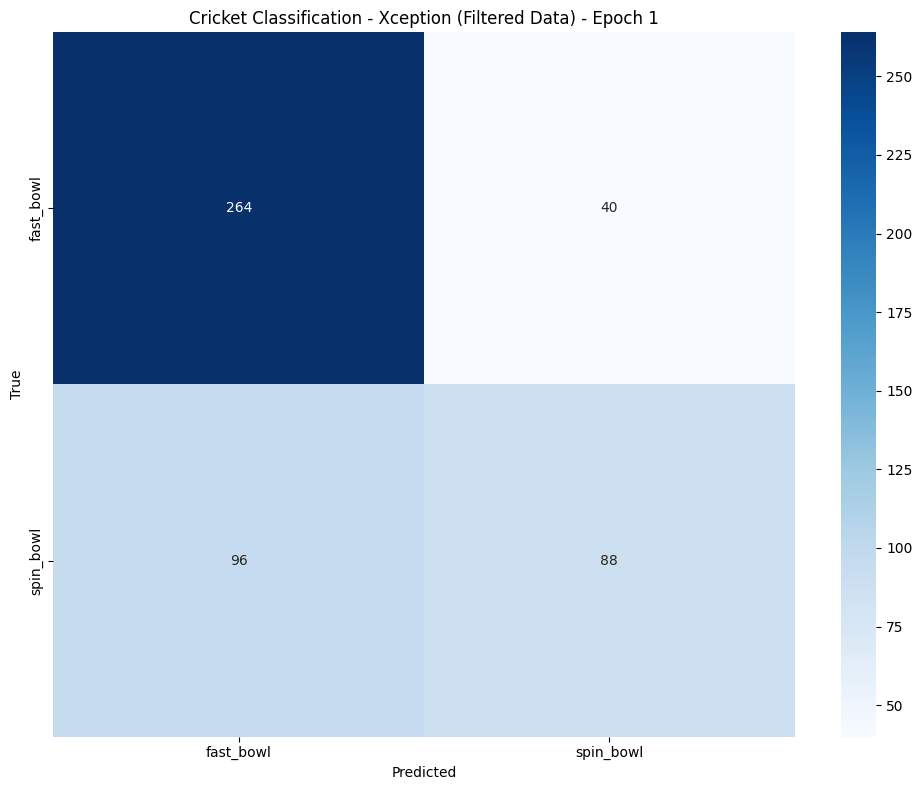

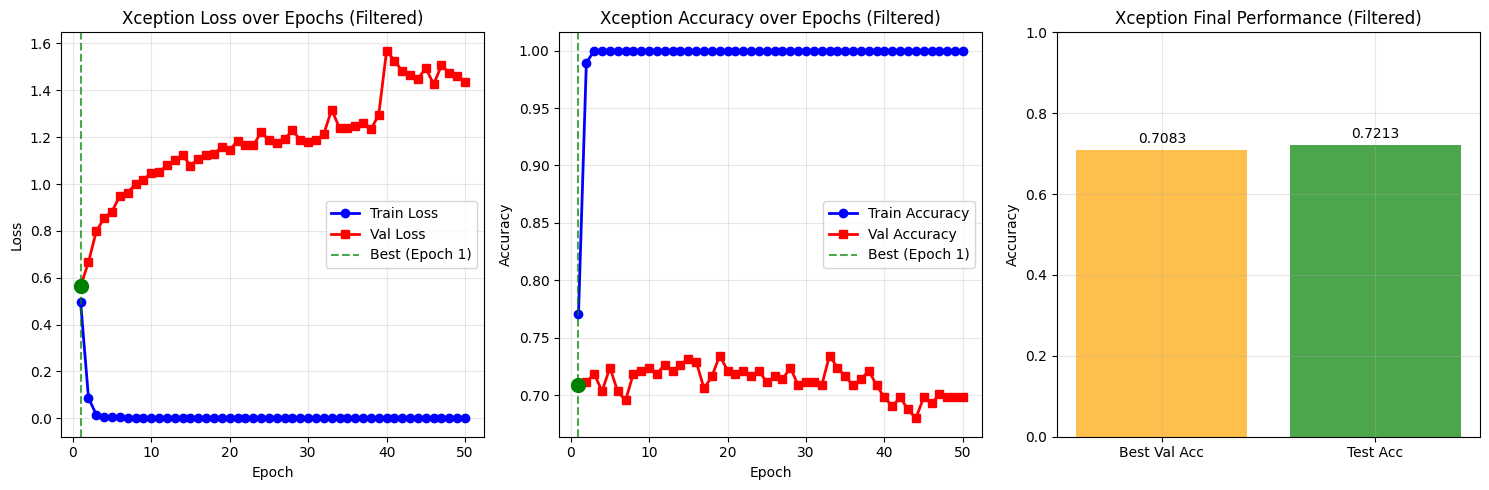


⏰ Final Timing Summary:
│ Total Training: 3062.61s (51.0 min)
│ Average per Epoch: 61.25s
│ Testing Time: 11.63s
│ Total Runtime: 3074.24s

🔀 Xception + Filtered Data Benefits:
│ Clean dataset: 'random_occlusion' folder excluded
│ Depthwise separable convolutions: More efficient than standard convolutions
│ Extreme version of Inception: Maximally decoupled cross-channel correlations
│ High resolution: 299x299 input captures fine details
│ [-1, 1] normalization: Xception-specific preprocessing
│ Excellent performance: Often matches InceptionV3 with fewer parameters


In [8]:
# -----------------------------
# 3. Training Setup
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Lower LR for fine-tuning

print(f"\n📋 Training Configuration:")
print(f"│ Model: Xception (pretrained via timm)")
print(f"│ Optimizer: Adam (lr={optimizer.param_groups[0]['lr']})")
print(f"│ Loss Function: CrossEntropyLoss")
print(f"│ Batch Size: 32")
print(f"│ Device: {device}")
print(f"│ Data: Filtered (excluding '{ignore_folder}')")
print(f"│ Normalization: [-1, 1] range (Xception specific)")

# -----------------------------
# 4. Training Loop with Model Saving
# -----------------------------
train_losses, val_losses = [], []
train_accs, val_accs = [], []
epoch_times = []
epochs = 50

# Initialize best model tracking (using val_loss for fine-tuning)
best_val_loss = float('inf')
best_model_state = None
best_epoch = 0
best_val_acc = 0.0

print(f"\n🚀 Starting Xception Fine-tuning for {epochs} epochs...")
print("=" * 80)
total_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    print(f"\n📈 Epoch {epoch+1}/{epochs}")
    print("-" * 50)
    
    # Training Phase
    print("🔄 Training Phase...")
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    train_pbar = tqdm(train_loader, desc="Training", 
                     bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    train_phase_start = time.time()
    
    for batch_idx, (imgs, labels) in enumerate(train_pbar):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        current_acc = correct / total
        train_pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{current_acc:.4f}'
        })
        
        if device.type == 'cuda' and batch_idx % 10 == 0:
            gpu_memory = torch.cuda.memory_allocated() / 1024**3
            train_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}',
                'GPU': f'{gpu_memory:.1f}GB'
            })
    
    train_phase_time = time.time() - train_phase_start
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    print(f"✅ Training completed in {train_phase_time:.2f}s")
    
    # Validation Phase
    print("🔍 Validation Phase...")
    model.eval()
    running_loss, correct, total = 0, 0, 0
    
    val_phase_start = time.time()
    val_pbar = tqdm(val_loader, desc="Validation", 
                   bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(val_pbar):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            current_acc = correct / total
            val_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}'
            })
    
    val_phase_time = time.time() - val_phase_start
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"✅ Validation completed in {val_phase_time:.2f}s")
    
    # Check if this is the best model (using val_loss for fine-tuning)
    is_best = val_loss < best_val_loss
    if is_best:
        best_val_loss = val_loss
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_model_state = model.state_dict().copy()
        print(f"🌟 New best model found! Validation Loss: {val_loss:.4f}")
    
    # Epoch Summary
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    
    print(f"\n📊 Epoch {epoch+1} Summary:")
    print(f"│ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"│ Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"│ Train Time: {train_phase_time:.2f}s | Val Time: {val_phase_time:.2f}s")
    print(f"│ Total Epoch Time: {epoch_time:.2f}s")
    print(f"│ Best Val Loss: {best_val_loss:.4f} (Epoch {best_epoch})")
    
    if device.type == 'cuda':
        print(f"│ GPU Memory: {torch.cuda.memory_allocated()/1024**3:.1f}GB / {torch.cuda.memory_reserved()/1024**3:.1f}GB")
    
    print("=" * 80)

total_training_time = time.time() - total_start_time

# Save the best model
if best_model_state is not None:
    torch.save(best_model_state, 'best_cricket_xception_filtered_pretrained.pth')
    print(f"\n💾 Best model saved as 'best_cricket_xception_filtered.pth'")
    print(f"📊 Best model stats:")
    print(f"│ Best Epoch: {best_epoch}")
    print(f"│ Best Val Loss: {best_val_loss:.4f}")
    print(f"│ Best Val Acc: {best_val_acc:.4f}")

# Save training history
history_data = {
    'epoch': list(range(1, epochs+1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs,
    'epoch_time': epoch_times
}

history_df = pd.DataFrame(history_data)
history_df.to_csv('cricket_xception_filtered_history_pretrained.csv', index=False)
print("\n💾 Training history saved to 'cricket_xception_filtered_history_pretrained.csv'")

print(f"\n🎉 Xception Fine-tuning Complete!")
print(f"Total Training Time: {total_training_time:.2f}s ({total_training_time/60:.1f} minutes)")
print(f"Average Epoch Time: {np.mean(epoch_times):.2f}s")

# -----------------------------
# 5. Load Best Model and Test
# -----------------------------
print(f"\n🧪 Loading Best Model for Testing...")
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"✅ Best model from epoch {best_epoch} loaded successfully!")

test_start_time = time.time()
y_true, y_pred = [], []
model.eval()
test_pbar = tqdm(test_loader, desc="Testing", 
                bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')

with torch.no_grad():
    for imgs, labels in test_pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_time = time.time() - test_start_time
test_accuracy = accuracy_score(y_true, y_pred)

print(f"✅ Testing completed in {test_time:.2f}s")
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))
print(f"🎯 Test Accuracy: {test_accuracy:.4f}")

# Performance Summary
print(f"\n📊 Cricket Classification Performance (Xception - Filtered Data):")
print(f"│ Best Validation Loss: {best_val_loss:.4f} (Epoch {best_epoch})")
print(f"│ Best Validation Acc:  {best_val_acc:.4f} (Epoch {best_epoch})")
print(f"│ Final Test Accuracy:  {test_accuracy:.4f}")
print(f"│ Val-Test Gap:         {abs(best_val_acc - test_accuracy):.4f}")
print(f"│ Data Filtering: Excluded '{ignore_folder}' folder")

print(f"\n💾 Files saved:")
print(f"│ best_cricket_xception_filtered.pth - Best model weights")
print(f"│ cricket_xception_filtered_history.csv - Training metrics")

# -----------------------------
# 6. Visualizations
# -----------------------------
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Cricket Classification - Xception (Filtered Data) - Epoch {best_epoch}")
plt.tight_layout()
plt.show()

# Training Curves
plt.figure(figsize=(15, 5))

# Loss Plot
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs+1), train_losses, 'b-', label="Train Loss", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_losses, 'r-', label="Val Loss", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_loss], color='green', s=100, zorder=5)
plt.legend()
plt.title("Xception Loss over Epochs (Filtered)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)

# Accuracy Plot
plt.subplot(1, 3, 2)
plt.plot(range(1, epochs+1), train_accs, 'b-', label="Train Accuracy", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_accs, 'r-', label="Val Accuracy", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_acc], color='green', s=100, zorder=5)
plt.legend()
plt.title("Xception Accuracy over Epochs (Filtered)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

# Final Performance
plt.subplot(1, 3, 3)
metrics = ['Best Val Acc', 'Test Acc']
values = [best_val_acc, test_accuracy]
colors = ['orange', 'green']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.title("Xception Final Performance (Filtered)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, 
             f'{val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Final Summary
print(f"\n⏰ Final Timing Summary:")
print(f"│ Total Training: {total_training_time:.2f}s ({total_training_time/60:.1f} min)")
print(f"│ Average per Epoch: {np.mean(epoch_times):.2f}s")
print(f"│ Testing Time: {test_time:.2f}s")
print(f"│ Total Runtime: {total_training_time + test_time:.2f}s")

# Model and Data Info
print(f"\n🔀 Xception + Filtered Data Benefits:")
print(f"│ Clean dataset: '{ignore_folder}' folder excluded")
print(f"│ Depthwise separable convolutions: More efficient than standard convolutions")
print(f"│ Extreme version of Inception: Maximally decoupled cross-channel correlations")
print(f"│ High resolution: 299x299 input captures fine details")
print(f"│ [-1, 1] normalization: Xception-specific preprocessing")
print(f"│ Excellent performance: Often matches InceptionV3 with fewer parameters")